In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datetime import datetime
from torchvision import datasets, transforms


device: cpu


C:\Users\정기연\AppData\Local\Temp\ipykernel_20612\208592621.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



after feature_extractor:
 tensor([[[[-0.0297]],

         [[ 0.1319]],

         [[ 0.0538]],

         ...,

         [[-0.1013]],

         [[ 0.0796]],

         [[ 0.0731]]],


        [[[-0.0419]],

         [[-0.0639]],

         [[ 0.0308]],

         ...,

         [[-0.0961]],

         [[-0.0339]],

         [[ 0.0642]]],


        [[[-0.0080]],

         [[ 0.1668]],

         [[ 0.0424]],

         ...,

         [[-0.1208]],

         [[ 0.1090]],

         [[ 0.0330]]],


        ...,


        [[[-0.0151]],

         [[ 0.1401]],

         [[ 0.0235]],

         ...,

         [[-0.0714]],

         [[ 0.1211]],

         [[ 0.0373]]],


        [[[ 0.0038]],

         [[ 0.1010]],

         [[ 0.0451]],

         ...,

         [[-0.1300]],

         [[ 0.0593]],

         [[ 0.0786]]],


        [[[ 0.0066]],

         [[ 0.0395]],

         [[ 0.0232]],

         ...,

         [[-0.1737]],

         [[ 0.0255]],

         [[ 0.0427]]]], grad_fn=<TanhBackward0>)

x.s

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

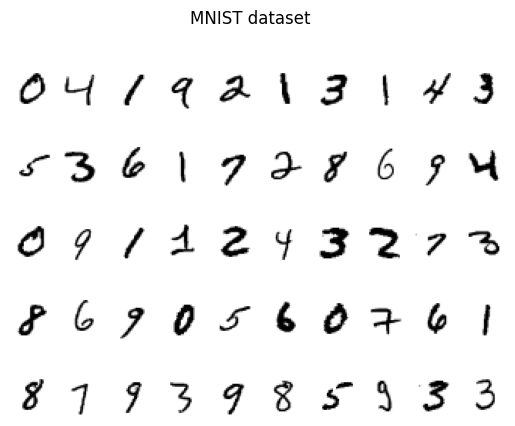

In [2]:
#

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("\ndevice:", device)

# data set, data loader

img_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="./data",
                               train=True,
                               transform=transform,
                               download=True)
valid_dataset = datasets.MNIST(root="./data",
                               train=False,
                               transform=transform,
                               download=True)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# data 확인

fig = plt.figure()

num_rows = 5
num_cols = 10

for idx in range(1, num_rows * num_cols + 1):
    plt.subplot(num_rows, num_cols, idx)
    plt.axis('off')
    plt.imshow(train_dataset.data[idx], cmap='gray_r')

fig.suptitle('MNIST dataset')

fig.show()

# model 정의

class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(), # -무한, +무한 --> -1, +1
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            
            nn.Linear(in_features=84, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.feature_extractor(x)
        print("\nafter feature_extractor:\n", x)
        print("\nx.shape:", x.shape)
        
        x = torch.flatten(x, 1)
        print("\nafter flatten:\n", x)
        print("\nx.shape:", x.shape)
        
        logits = self.classifier(x)
        print("\nafter classifier: logits:\n", logits)
        print("\nlogits.shape:", logits.shape)
        
        probs = F.softmax(logits.float(), dim=1)
        print("\nafter softmax: probs:\n", probs)
        print("\nprobs.shape:", probs.shape)
        
        return logits, probs
    
# function 정의

def training(train_dataloader, model, criterion, optimizer, device):
    model.train()
    
    loss_per_epoch = 0.0 
    
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        _, probs = model(x)
        
        _, labels = torch.max(probs, 1)
        
        loss = criterion(labels.float(), y.float())
        
        loss_per_epoch += loss
        
        loss.backward()
        
        optimizer.step()
        
    return model, optimizer, loss_per_epoch
    
def validation():
    pass

def get_acc(model, dataloader, device):
    correct = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            _, probs = model(x)
            
            _, labels = torch.max(probs, 1)
            
            total += y.size(0)
            correct += (labels == y).sum()
            
    return correct.float() / total

#

model = LeNet5(10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

a, b, c = training(train_dataloader, model, criterion, optimizer, device)